## CS310 Natural Language Processing
## Assignment 4. Long Short Term Memory (LSTM) Network for Named Entity Recognition (NER)

**Total points**: 50 + (10 bonus)

In this assignment, you will implement a Long Short Term Memory (LSTM) network for Named Entity Recognition (NER). 

Re-use the code in Lab 5.

### 0. Import Necessary Libraries

In [44]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
import re
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle

from utils import Indexer, read_ner_data_from_connl, get_batch

from metrics import MetricsHandler


In [45]:
torch.manual_seed(42)
np.random.seed(42)

os.environ["CUDA_VISIBLE_DEVICES"] = "4" 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用设备: {device}")

DATA_DIR = '/home/stu_12310401/nlp/SUSTech-NLP25/Ass4/data'
GLOVE_PATH = '/home/stu_12310401/nlp/SUSTech-NLP25/Ass4/glove.6B.100d.txt'

BATCH_SIZE = 128
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
NUM_LAYERS = 2
DROPOUT = 0.5
LEARNING_RATE = 0.001
NUM_EPOCHS = 10

使用设备: cuda


In [46]:
class NERDataset(Dataset):
    def __init__(self, sentences, tags, word_to_idx, tag_to_idx):
        self.sentences = sentences
        self.tags = tags
        self.word_to_idx = word_to_idx
        self.tag_to_idx = tag_to_idx
        
    def __len__(self):
        return len(self.sentences)
    
    def __getitem__(self, idx):
        words = self.sentences[idx]
        tags = self.tags[idx]
        
        word_idxs = [self.word_to_idx.get(word.lower(), self.word_to_idx['<UNK>']) for word in words]
        tag_idxs = [self.tag_to_idx[tag] for tag in tags]
        
        return torch.tensor(word_idxs), torch.tensor(tag_idxs)

In [47]:
def build_vocab(sentences, tags, min_freq=1):
    word_counts = Counter()
    for sentence in sentences:
        word_counts.update([word.lower() for word in sentence])
    
    word_to_idx = {'<PAD>': 0, '<UNK>': 1}
    for word, count in word_counts.items():
        if count >= min_freq:
            word_to_idx[word] = len(word_to_idx)
    
    tag_counts = Counter()
    for sentence_tags in tags:
        tag_counts.update(sentence_tags)
    
    tag_to_idx = {'<PAD>': 0}
    for tag in tag_counts:
        tag_to_idx[tag] = len(tag_to_idx)
    
    return word_to_idx, tag_to_idx

In [48]:
def load_glove_embeddings(glove_path, word_to_idx, embedding_dim=100):
    """加载预训练的GloVe词向量"""
    embeddings = np.random.uniform(-0.25, 0.25, (len(word_to_idx), embedding_dim))
    embeddings[0] = np.zeros(embedding_dim)
    
    word_count = 0
    with open(glove_path, 'r', encoding='utf-8') as f:
        for line in tqdm(f, desc="加载GloVe词向量"):
            values = line.split()
            word = values[0]
            if word.lower() in word_to_idx:
                vector = np.array(values[1:], dtype='float32')
                embeddings[word_to_idx[word.lower()]] = vector
                word_count += 1
    
    print(f"加载了 {word_count}/{len(word_to_idx)} 个词的预训练词向量")
    return torch.FloatTensor(embeddings)

In [49]:
def collate_fn(batch):
    batch.sort(key=lambda x: len(x[0]), reverse=True)
    sentences, tags = zip(*batch)
    
    lengths = [len(s) for s in sentences]
    max_len = max(lengths)
    
    padded_sentences = torch.zeros(len(sentences), max_len).long()
    padded_tags = torch.zeros(len(sentences), max_len).long()
    
    for i, (sentence, tag) in enumerate(zip(sentences, tags)):
        end = lengths[i]
        padded_sentences[i, :end] = sentence[:end]
        padded_tags[i, :end] = tag[:end]
    
    return padded_sentences, padded_tags, torch.tensor(lengths)

In [50]:
def load_data(file_path):
    """加载CoNLL2003格式的NER数据"""
    sentences = []
    tags = []
    
    sentence = []
    sentence_tags = []
    
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if line == '' or line.startswith('-DOCSTART-'):
                if sentence:
                    sentences.append(sentence)
                    tags.append(sentence_tags)
                    sentence = []
                    sentence_tags = []
            else:
                parts = line.split()
                if len(parts) >= 4:  # CoNLL格式：单词 POS NP 标签
                    word = parts[0]
                    tag = parts[3]
                    sentence.append(word)
                    sentence_tags.append(tag)
    
    # 添加最后一个句子
    if sentence:
        sentences.append(sentence)
        tags.append(sentence_tags)
    
    return sentences, tags

### 1. Build the Model

In [51]:
class BiLSTM_NER(nn.Module):
    def __init__(self, vocab_size, tag_size, embedding_dim, hidden_dim, num_layers, dropout, pretrained_embeddings=None):
        super(BiLSTM_NER, self).__init__()
        

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        if pretrained_embeddings is not None:
            self.embedding.weight = nn.Parameter(pretrained_embeddings)
        

        self.lstm = nn.LSTM(embedding_dim, 
                           hidden_dim // 2,  
                           num_layers=num_layers, 
                           bidirectional=True,
                           batch_first=True,
                           dropout=dropout if num_layers > 1 else 0)
        

        self.fc = nn.Linear(hidden_dim, tag_size)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, lengths):

        embedded = self.dropout(self.embedding(x))
        
        packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True)
        
        outputs, _ = self.lstm(packed)
        
        outputs, _ = nn.utils.rnn.pad_packed_sequence(outputs, batch_first=True)
        
        outputs = self.dropout(outputs)
        
        logits = self.fc(outputs)
        
        return logits

### 2. Train and Evaluate

In [52]:
def train(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    
    for sentences, tags, lengths in tqdm(train_loader, desc="训练"):
        sentences = sentences.to(device)
        tags = tags.to(device)
        
        optimizer.zero_grad()
        logits = model(sentences, lengths)
        
        loss = 0
        for i in range(logits.size(0)):
            loss += criterion(logits[i, :lengths[i]], tags[i, :lengths[i]])
        loss /= logits.size(0)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(train_loader)

In [53]:
def evaluate(model, data_loader, tag_to_idx, idx_to_tag, metrics_handler, device):
    model.eval()
    metrics_handler = MetricsHandler(classes=list(tag_to_idx.keys()))
    
    with torch.no_grad():
        for sentences, tags, lengths in tqdm(data_loader, desc="评估"):
            sentences = sentences.to(device)
            tags = tags.to(device)

            logits = model(sentences, lengths)

            for i in range(logits.size(0)):
                length = lengths[i]
                logits_i = logits[i, :length]
                tags_i = tags[i, :length]
                
                # 贪心
                _, predicted = torch.max(logits_i, dim=1)
                
                pred_tags = [idx_to_tag[idx.item()] for idx in predicted]
                true_tags = [idx_to_tag[idx.item()] for idx in tags_i]
                
                metrics_handler.update(pred_tags, true_tags)
    
    metrics_handler.collect()
    metrics = metrics_handler.get_metrics()
    
    f1_scores = metrics["F1-score"]
    latest_f1 = f1_scores[-1] if f1_scores else 0.0
    
    return {"f1": latest_f1, "metrics": metrics}

In [54]:
from utils import get_tag_indices_from_scores
from metrics import MetricsHandler

labels_str = ['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC']
labels_int = list(range(len(labels_str)))
train_metrics = MetricsHandler(labels_int)

train_sentences, train_tags = load_data(os.path.join(DATA_DIR, 'train.txt'))
dev_sentences, dev_tags = load_data(os.path.join(DATA_DIR, 'dev.txt'))
test_sentences, test_tags = load_data(os.path.join(DATA_DIR, 'test.txt'))

word_to_idx, tag_to_idx = build_vocab(train_sentences, train_tags)
idx_to_tag = {idx: tag for tag, idx in tag_to_idx.items()}

TAGSET_SIZE = len(tag_to_idx)

print(f"TARGET SIZE: {TAGSET_SIZE}")

pretrained_embeddings = load_glove_embeddings(GLOVE_PATH, word_to_idx, EMBEDDING_DIM)

train_dataset = NERDataset(train_sentences, train_tags, word_to_idx, tag_to_idx)
dev_dataset = NERDataset(dev_sentences, dev_tags, word_to_idx, tag_to_idx)
test_dataset = NERDataset(test_sentences, test_tags, word_to_idx, tag_to_idx)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

model = BiLSTM_NER(
    vocab_size=len(word_to_idx),
    tag_size=len(tag_to_idx),
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT,
    pretrained_embeddings=pretrained_embeddings
).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=tag_to_idx['<PAD>'])
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


metrics_handler = MetricsHandler(classes=list(range(TAGSET_SIZE)))


TARGET SIZE: 10


加载GloVe词向量: 400000it [00:02, 162496.66it/s]


加载了 18415/21011 个词的预训练词向量


In [55]:
print("开始训练...")
train_losses = []
dev_f1_scores = []

for epoch in range(NUM_EPOCHS):

    train_loss = train(model, train_loader, optimizer, criterion, device)
    train_losses.append(train_loss)
    

    dev_metrics = evaluate(model, dev_loader, tag_to_idx, idx_to_tag, metrics_handler, device)
    dev_f1 = dev_metrics['f1']
    dev_f1_scores.append(dev_f1)
    
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Loss: {train_loss:.4f}, Dev set F1: {dev_f1:.4f}")
    
    if epoch < 5:
        print(f"Epoch {epoch+1} Dev set F1 score: {dev_f1:.4f}")

# Evaluate on the test set
print("Evaluating on the test set...")
test_metrics = evaluate(model, test_loader, tag_to_idx, idx_to_tag, metrics_handler, device)
test_f1 = test_metrics['f1']
print(f"Test set F1 score: {test_f1:.4f}")

torch.save({
    'model_state_dict': model.state_dict(),
    'word_to_idx': word_to_idx,
    'tag_to_idx': tag_to_idx,
    'idx_to_tag': idx_to_tag,
    'hyperparams': {
        'embedding_dim': EMBEDDING_DIM,
        'hidden_dim': HIDDEN_DIM,
        'num_layers': NUM_LAYERS,
        'dropout': DROPOUT
    }
}, 'bilstm_ner_model.pt')

开始训练...


评估: 100%|██████████| 26/26 [00:02<00:00, 12.15it/s]
/home/stu_12310401/nlp/SUSTech-NLP25/Ass4/metrics.py:5: RuntimeWarning: invalid value encountered in scalar divide
  return x[1, 1]/(x[1, 1] + x[0, 1])
/home/stu_12310401/nlp/SUSTech-NLP25/Ass4/metrics.py:9: RuntimeWarning: invalid value encountered in scalar divide
  return x[1, 1] / (x[1, 0] + x[1, 1])


Epoch 1/10, Loss: 0.8772, Dev set F1: 0.6758
Epoch 1 Dev set F1 score: 0.6758


评估: 100%|██████████| 26/26 [00:02<00:00, 12.15it/s]


Epoch 2/10, Loss: 0.3592, Dev set F1: 0.6671
Epoch 2 Dev set F1 score: 0.6671


评估: 100%|██████████| 26/26 [00:02<00:00, 12.08it/s]


Epoch 3/10, Loss: 0.2272, Dev set F1: 0.7535
Epoch 3 Dev set F1 score: 0.7535


评估: 100%|██████████| 26/26 [00:02<00:00, 12.25it/s]


Epoch 4/10, Loss: 0.1828, Dev set F1: 0.7686
Epoch 4 Dev set F1 score: 0.7686


评估: 100%|██████████| 26/26 [00:02<00:00, 12.13it/s]


Epoch 5/10, Loss: 0.1519, Dev set F1: 0.7945
Epoch 5 Dev set F1 score: 0.7945


评估: 100%|██████████| 26/26 [00:02<00:00, 11.76it/s]


Epoch 6/10, Loss: 0.1318, Dev set F1: 0.8139


评估: 100%|██████████| 26/26 [00:02<00:00, 12.52it/s]


Epoch 7/10, Loss: 0.1174, Dev set F1: 0.8168


评估: 100%|██████████| 26/26 [00:02<00:00, 12.22it/s]


Epoch 8/10, Loss: 0.1061, Dev set F1: 0.8262


评估: 100%|██████████| 26/26 [00:02<00:00, 12.08it/s]


Epoch 9/10, Loss: 0.0952, Dev set F1: 0.8335


评估: 100%|██████████| 26/26 [00:02<00:00, 12.27it/s]


Epoch 10/10, Loss: 0.0868, Dev set F1: 0.8374
Evaluating on the test set...


评估: 100%|██████████| 27/27 [00:01<00:00, 14.02it/s]

Test set F1 score: 0.7860


### 3. Other Experiments

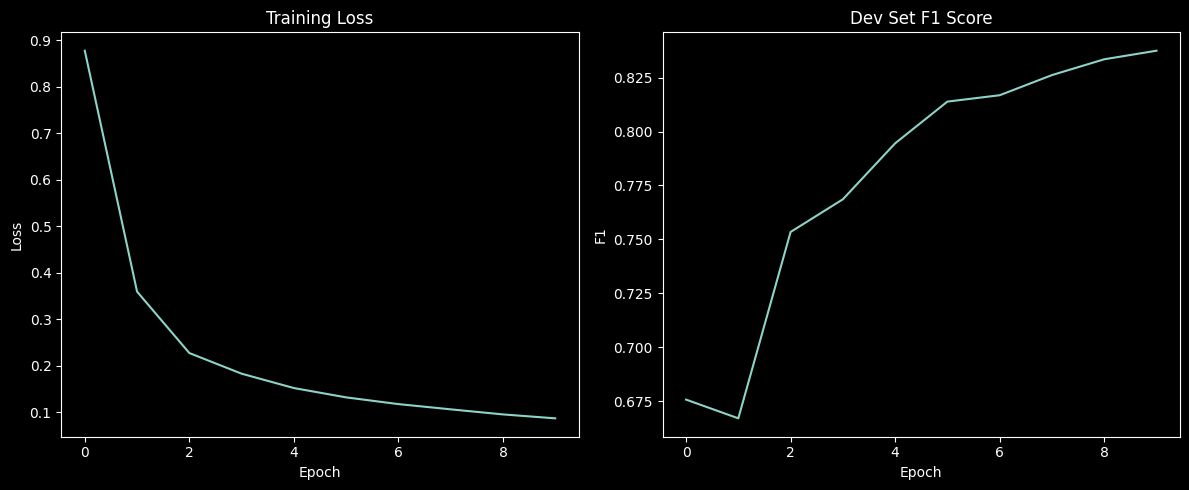

In [58]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(dev_f1_scores)
plt.title('Dev Set F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1')

plt.tight_layout()
plt.savefig('training_curves.png')
plt.show()